# Project Configs and Imports

In [1]:
import os
import re
from datetime import datetime as dt
from typing import Dict, List, Optional, Tuple
import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import email
from dateutil import parser
import calendar
from tqdm import tqdm
import pickle
import gensim
from gensim.models import KeyedVectors, Word2Vec
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')
np.random.seed(67)

/home/kaho/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
[nltk_data] Downloading package stopwords to /home/kaho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kaho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Configuration
CONFIG = {
    'dataset_directory': "siftmail/Datasets/",
    'models_directory': "siftmail/Models/",
    'logs_directory': "siftmail/Logs/",
    'figures_directory': "siftmail/Figures/"
}

# Create directories if they don't exist
for directory in CONFIG.values():
    os.makedirs(directory, exist_ok=True)
    logger.info(f"Ensured directory exists: {directory}")

2025-08-04 17:26:08,869 - INFO - Ensured directory exists: siftmail/Datasets/
2025-08-04 17:26:08,869 - INFO - Ensured directory exists: siftmail/Models/
2025-08-04 17:26:08,870 - INFO - Ensured directory exists: siftmail/Logs/
2025-08-04 17:26:08,870 - INFO - Ensured directory exists: siftmail/Figures/


# Loading Original Data

In [4]:
def load_data(filepath: str) -> pd.DataFrame:
    try:
        logger.info(f"Loading data from {filepath}")
        data = pd.read_csv(filepath)
        if data.empty:
            raise ValueError("Dataset is empty")
        
        logger.info(f"Loaded {len(data)} rows and {len(data.columns)} columns")
        return data
    except FileNotFoundError:
        logger.error(f"File not found: {filepath}")
        raise
    except Exception as e:
        logger.error(f"Error loading data: {str(e)}")
        raise

dataset_OG = load_data(os.path.join(CONFIG['dataset_directory'], "emails.csv"))
data = dataset_OG.copy()

print(f"Dataset shape: {data.shape}")
print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

2025-08-04 17:22:03,720 - INFO - Loading data from siftmail/Datasets/emails.csv
2025-08-04 17:22:08,900 - INFO - Loaded 517401 rows and 2 columns


Dataset shape: (517401, 2)
Memory usage: 1411.48 MB


# Feature Extractions 


### Extracting Headers

Parse and extract specified headers from raw emails. 

In [5]:
class EmailHeaderExtractor:
    
    def __init__(self, header_names: List[str]):
        self.header_names = header_names
    
    def insert_value(self, dictionary: Dict, key: str, value: str) -> Dict:
        if key in dictionary:
            dictionary[key].append(value)
        else:
            dictionary[key] = [value]
        return dictionary
    
    def get_headers(self, df: pd.DataFrame) -> Dict[str, List[str]]:
        headers = {name: [] for name in self.header_names}
        
        for idx, message in enumerate(df["message"]):
            try:
                e = email.message_from_string(message)
                for header_name in self.header_names:
                    header_value = e.get(header_name, None)
                    headers[header_name].append(header_value)
            except Exception as e:
                logger.warning(f"Error processing message {idx}: {str(e)}")
                # Add None for all headers for this message
                for header_name in self.header_names:
                    headers[header_name].append(None)
        
        logger.info("Successfully retrieved header information!")
        return headers

header_names = ["Date", "Subject", "X-Folder", "X-From", "X-To"]
extractor = EmailHeaderExtractor(header_names)
headers = extractor.get_headers(data)

for key, values in headers.items():
    data[key] = values

2025-08-04 17:22:31,255 - INFO - Successfully retrieved header information!


In [5]:
#Debug info
#data.head()

### Extracting Messages

In [6]:
def get_messages(df: pd.DataFrame, max_length: int = 10000) -> List[str]:
    messages = []
    
    for idx, item in enumerate(df["message"]):
        try:
            e = email.message_from_string(item)
            message_body = e.get_payload()
            
            if message_body:
                message_body = message_body.lower().strip()
                if len(message_body) > max_length:
                    message_body = message_body[:max_length]
                    logger.debug(f"Truncated message {idx} to {max_length} characters")
            else:
                message_body = ""
                
            messages.append(message_body)
            
        except Exception as e:
            logger.warning(f"Error processing message {idx}: {str(e)}")
            messages.append("")
    
    logger.info("Successfully retrieved message bodies!")
    return messages

data["Message-Body"] = get_messages(data, max_length=10000)

2025-08-04 17:22:50,931 - INFO - Successfully retrieved message bodies!


In [7]:
#Debug info
#data.head()

### Extract Employee Names

In [ ]:
def extract_employee_name(file_path: str) -> str:
    try:
        tokens = file_path.split('/')
        return tokens[0] if tokens else "unknown"
    except Exception:
        return "unknown"
data['employee'] = data['file'].apply(extract_employee_name)

In [9]:
#debug info
#data.head()

# Date -> Datetime Conversion

Due to inconsistency, it is difficult to parse reliably. We need to conver the raw date strings into proper datetime ojbects. Parsing will handle both typical formats and fallback cases, which will allow us to safely extract day of the week. 

In [7]:

class DateProcessor:
    @staticmethod
    def month_mapping(month_str: str) -> int:
        month_map = {abbr: num for num, abbr in enumerate(calendar.month_abbr)}
        return month_map.get(month_str, 1)
    
    @staticmethod
    def extract_date(date_string: str) -> Optional[dt]:
        if pd.isna(date_string):
            return None
            
        try:
            if isinstance(date_string, str):
                if re.match(r'\w{3}, \d{1,2} \w{3} \d{4}', date_string):
                    date_array = re.split(" ", date_string)
                    time_array = re.split(":", date_array[4])
                    return dt(
                        year=int(date_array[3]),
                        month=DateProcessor.month_mapping(date_array[2]),
                        day=int(date_array[1]),
                        hour=int(time_array[0]),
                        minute=int(time_array[1]),
                        second=int(time_array[2])
                    )
                else:
                    return parser.parse(date_string)
        except Exception as e:
            logger.warning(f"Could not parse date '{date_string}': {str(e)}")
            return None

processor = DateProcessor()
data['Date_datetime'] = data['Date'].apply(processor.extract_date)
data['Day_of_week'] = data['Date'].apply(lambda x: re.split(" ", x)[0][:-1] if pd.notna(x) else None)

In [11]:
#debug info
#data.head()

### X-Folder Contents

In [8]:
def extract_folder_contents(x: str) -> str:
    if pd.isna(x):
        return "unknown"
    
    try:
        # Handle both forward and backward slashes
        if '\\' in str(x):
            return re.split(r'\\+', str(x))[-1].lower()
        elif '/' in str(x):
            return re.split(r'/+', str(x))[-1].lower()
        else:
            return str(x).lower()
    except Exception:
        return "unknown"

data['X-Folder-split'] = data['X-Folder'].apply(extract_folder_contents)

data['message_length'] = data['Message-Body'].str.len().fillna(0)

columns_to_drop = ['file', 'X-From', 'X-Folder', 'X-To', 'employee']
data = data.drop(columns_to_drop, axis=1, errors='ignore')

In [ ]:
class MessageFeatureExtractor:

    @staticmethod
    def extract_message_features(df: pd.DataFrame) -> pd.DataFrame:

        df = df.copy()

        df['contains-cc'] = df.message.str.contains(r'X-cc: .+', na=False).astype(int)
        df['contains-bcc'] = df.message.str.contains(r'X-bcc: .+', na=False).astype(int)
        

        df['has_attachments'] = df.message.str.contains(r'Content-Type: multipart', na=False).astype(int)
        df['is_reply'] = df.message.str.contains(r'Re:', na=False).astype(int)
        df['is_forward'] = df.message.str.contains(r'Fwd:', na=False).astype(int)
        

        if 'Date_datetime' in df.columns:

            df['Date_datetime'] = pd.to_datetime(df['Date_datetime'], errors='coerce')
            

            df['hour'] = df['Date_datetime'].dt.hour.fillna(-1).astype(int)
            df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)
        else:
            print("Warning: Date_datetime column not found. Skipping time-based features.")
            df['hour'] = -1
            df['is_business_hours'] = 0
        
        
        df['word_count'] = df['Message-Body'].str.split().str.len().fillna(0)
        df['has_links'] = df['Message-Body'].str.contains(r'http[s]?://', na=False).astype(int)
        
        return df

extractor = MessageFeatureExtractor()
data = extractor.extract_message_features(data)

try:
    data.to_csv(os.path.join(CONFIG['dataset_directory'], "preprocessed_data.csv"), index=False)
    print("Successfully saved preprocessed data")
except Exception as e:
    print(f"Error saving data: {str(e)}")

Successfully saved preprocessed data


In [10]:
#Debug info + Exploration
data.head()
data.columns
print(data['message'][1])

Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>
Date: Fri, 4 May 2001 13:51:00 -0700 (PDT)
From: phillip.allen@enron.com
To: john.lavorato@enron.com
Subject: Re:
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.

As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the

## Creating Embedding

In [6]:
data = pd.read_csv(os.path.join(CONFIG['dataset_directory'], "preprocessed_data.csv"))

In [7]:
data2 = data.copy()

In [8]:
class TextEmbedder:
    
    def __init__(self, model_path: str, embedding_dim: int = 300):
        self.embedding_dim = embedding_dim
        self.model = self._load_model(model_path)
    
    def _load_model(self, model_path: str):
        try:
            if os.path.exists(model_path):
                logger.info(f"Loading model from {model_path}")
                return KeyedVectors.load_word2vec_format(model_path, binary=True)
            else:
                logger.warning(f"Model not found at {model_path}. Skipping embedding creation.")
                return None
        except Exception as e:
            logger.error(f"Error loading model: {str(e)}")
            return None
    
    def remove_unnecessary_words(self, text: str) -> str:
        if pd.isna(text):
            return ""
        
        try:
            tokenized = word_tokenize(text.lower())
            add_to_stopwords = ['items', 'item', 'mails', 'mail', 'inboxes', 'inbox', 'threads', 'thread']
            to_remove = set(stopwords.words('english') + add_to_stopwords)
            cleaned = [word for word in tokenized if word not in to_remove]
            return ' '.join(cleaned)
        except Exception:
            return ""
    
    def vector_rep(self, word: str) -> np.ndarray:
        if self.model is None or word not in self.model.key_to_index:
            return np.zeros(self.embedding_dim)
        return self.model[word]
    
    def general_vector_rep(self, phrase: str) -> np.ndarray:
        if not phrase or self.model is None:
            return np.zeros(self.embedding_dim)
        
        tokenized = word_tokenize(phrase)
        if len(tokenized) == 0:
            return np.zeros(self.embedding_dim)
        
        vectors = []
        for word in tokenized:
            vectors.append(self.vector_rep(word))
        
        return np.mean(vectors, axis=0)
    
    def create_folder_embeddings(self, df: pd.DataFrame) -> pd.DataFrame:
        if self.model is None:
            logger.warning("Model not available. Skipping embedding creation.")
            return pd.DataFrame()
        
        df['X-Folder-split_cleaned'] = df['X-Folder-split'].apply(self.remove_unnecessary_words)
        df['X-Folder-split_cleaned'] = df['X-Folder-split_cleaned'].apply(
            lambda x: ''.join(c for c in x if c not in string.punctuation)
        )
        
        unique_folders = df['X-Folder-split_cleaned'].unique()
        embeddings = {}
        
        for folder in tqdm(unique_folders, desc="Creating embeddings"):
            embeddings[folder] = self.general_vector_rep(folder)
        
        return pd.DataFrame.from_dict(embeddings, orient='index')


model_path = os.path.join(CONFIG['models_directory'], 'GoogleNews-vectors-negative300.bin.gz')
embedder = TextEmbedder(model_path)

if embedder.model is not None:
    vec_folders = embedder.create_folder_embeddings(data2)
    vec_folders.to_csv(os.path.join(CONFIG['dataset_directory'], "vec_folders.csv"))

2025-08-04 17:27:10,589 - INFO - Loading model from siftmail/Models/GoogleNews-vectors-negative300.bin.gz
2025-08-04 17:27:10,590 - INFO - loading projection weights from siftmail/Models/GoogleNews-vectors-negative300.bin.gz
2025-08-04 17:27:32,538 - INFO - KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from siftmail/Models/GoogleNews-vectors-negative300.bin.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2025-08-04T17:27:32.538080', 'gensim': '4.3.3', 'python': '3.10.12 (main, May 27 2025, 17:12:29) [GCC 11.4.0]', 'platform': 'Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}
Creating embeddings: 100%|███████████████████████████████████████████████████████| 1747/1747 [00:00<00:00, 32519.47it/s]


# Performing Clustering

Finding optimal clusters: 100%|█████████████████████████████████████████████████████████| 18/18 [00:19<00:00,  1.10s/it]


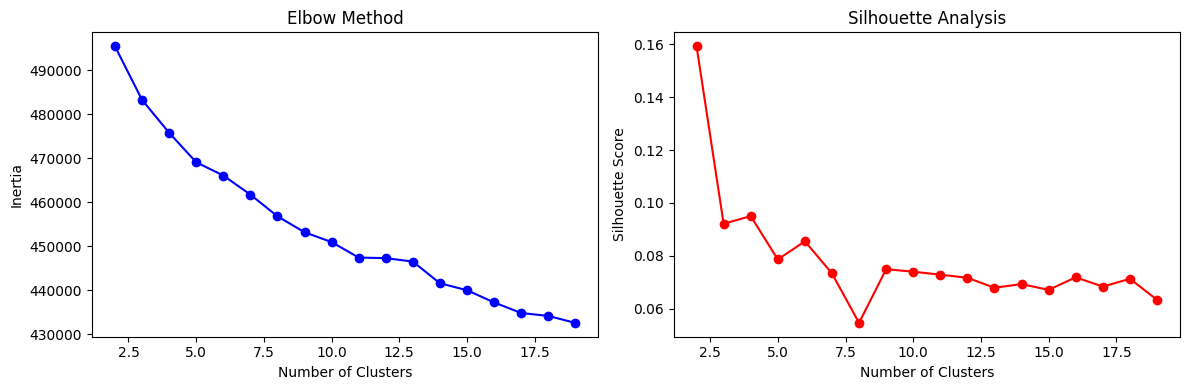

2025-08-04 17:25:22,303 - INFO - Clustering completed with 10 clusters


In [14]:
class FolderClusterer:
    
    def __init__(self, n_clusters: int = 10):
        self.n_clusters = n_clusters
    
    def find_optimal_clusters(self, data: np.ndarray, max_clusters: int = 20) -> int:
        inertias = []
        silhouette_scores = []
        K_range = range(2, min(max_clusters, len(data)))
        
        for k in tqdm(K_range, desc="Finding optimal clusters"):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(data)
            inertias.append(kmeans.inertia_)
            
            if k > 1:
                labels = kmeans.labels_
                silhouette_scores.append(silhouette_score(data, labels))
            else:
                silhouette_scores.append(0)
        
        #Elbow Curve Plot
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(K_range, inertias, 'bo-')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method')
        plt.subplot(1, 2, 2)
        plt.plot(K_range, silhouette_scores, 'ro-')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Analysis')
        plt.tight_layout()
        plt.show()
        return self.n_clusters
    
    def cluster_folders(self, embeddings_df: pd.DataFrame) -> Tuple[pd.DataFrame, KMeans]:
        if embeddings_df.empty:
            logger.warning("No embeddings available for clustering")
            return pd.DataFrame(), None
        X = embeddings_df.values
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        optimal_k = self.find_optimal_clusters(X_scaled)
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        results = embeddings_df.reset_index().rename(columns={'index': 'subject'})
        results['label'] = labels
        
        logger.info(f"Clustering completed with {optimal_k} clusters")
        return results, kmeans

clusterer = FolderClusterer(n_clusters=10)
if not vec_folders.empty:
    clustered_folders, kmeans_model = clusterer.cluster_folders(vec_folders)
    clustered_folders.to_csv(os.path.join(CONFIG['dataset_directory'], "vec_folders_labels.csv"), index=False)

In [16]:
vec_folders.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
sent,-0.017090,0.021729,0.225586,-0.129883,-0.199219,-0.107910,-0.184570,-0.083984,0.004974,0.111328,...,-0.148438,-0.283203,-0.051758,0.112305,0.267578,0.059082,0.144531,-0.091309,-0.069824,-0.021606
documents,0.097656,0.063965,0.024658,-0.151367,-0.032471,0.110352,0.044678,0.195312,0.089844,-0.285156,...,0.099121,-0.245117,-0.113770,0.026367,-0.156250,0.119141,0.073730,-0.292969,-0.035889,0.032959
contacts,0.074219,0.001274,0.065918,-0.086914,-0.070801,0.249023,-0.320312,-0.174805,0.091797,-0.052734,...,0.022583,0.097656,0.023071,-0.063965,0.114258,0.015869,0.416016,-0.140625,-0.050537,-0.033447
deleted,-0.172852,-0.047852,0.316406,0.145508,-0.220703,0.009521,-0.028076,0.216797,0.507812,0.092285,...,0.181641,0.076660,0.363281,-0.200195,0.287109,-0.263672,0.196289,-0.361328,-0.050537,-0.070801
discussion,-0.039062,0.042236,0.014465,0.115234,0.132812,-0.101074,0.164062,-0.100098,0.123535,0.005585,...,-0.011292,-0.175781,0.326172,0.152344,0.042236,-0.011536,-0.125000,-0.229492,-0.112305,-0.158203


In [20]:
data2.head()

,message,Date,Subject,Message-Body,Date_datetime,Day_of_week,X-Folder-split,message_length,contains-cc,contains-bcc,has_attachments,is_reply,is_forward,hour,is_business_hours,word_count,has_links,X-Folder-split_cleaned
0,Message-ID: <18782981.1075855378110.JavaMail.e...,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",NaN,here is our forecast,2001-05-14 16:39:00,Mon,'sent mail,20,0,0,0,0,0,16,1,4,0,sent
1,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,traveling to have a business meeting takes the...,2001-05-04 13:51:00,Fri,'sent mail,785,0,0,0,1,0,13,1,139,0,sent
2,Message-ID: <24216240.1075855687451.JavaMail.e...,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,test successful. way to go!!!,2000-10-18 03:00:00,Wed,'sent mail,30,0,0,0,1,0,3,0,5,0,sent
3,Message-ID: <13505866.1075863688222.JavaMail.e...,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",NaN,"randy,\n\n can you send me a schedule of the s...",2000-10-23 06:13:00,Mon,'sent mail,187,0,0,0,0,0,6,0,34,0,sent
4,Message-ID: <30922949.1075863688243.JavaMail.e...,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",Re: Hello,let's shoot for tuesday at 11:45.,2000-08-31 05:07:00,Thu,'sent mail,33,0,0,0,1,0,5,0,6,0,sent


## Joining Clustering Results with Main DF

In [12]:
def merge_and_filter_data(data: pd.DataFrame, labels_df: pd.DataFrame) -> pd.DataFrame:
    merged_data = data.merge(
        right=labels_df[['subject', 'label']],
        how='left',
        left_on='X-Folder-split_cleaned',
        right_on='subject'
    )
    merge_stats = {
        'total_rows': len(data),
        'matched_rows': merged_data['label'].notna().sum(),
        'unmatched_rows': merged_data['label'].isna().sum(),
        'match_rate': merged_data['label'].notna().mean()
    }
    
    logger.info(f"Merge statistics: {merge_stats}")

    labels_to_exclude = [1, 2]
    filtered_data = merged_data[~merged_data['label'].isin(labels_to_exclude)]
    
    logger.info(f"Filtered data shape: {filtered_data.shape}")
    return filtered_data


data_filtered = data2.copy()

In [9]:
# Create and save embedded dataset
def create_embedded_dataset(data: pd.DataFrame, vec_folders: pd.DataFrame) -> pd.DataFrame:
    """
    Create embedded dataset by combining preprocessed data with folder embeddings.
    
    Args:
        data: Preprocessed email data
        vec_folders: DataFrame with folder embeddings
    
    Returns:
        DataFrame with embedded features
    """
    logger.info("Creating embedded dataset...")

    folder_embeddings = {}
    for folder_name in vec_folders.index:
        folder_embeddings[folder_name] = vec_folders.loc[folder_name].values
    embedded_data = data.copy()
    embedding_dim = len(vec_folders.columns)
    embedding_columns = [f'embedding_{i}' for i in range(embedding_dim)]
    for col in embedding_columns:
        embedded_data[col] = 0.0

    matched_count = 0
    for idx, row in embedded_data.iterrows():
        folder_name = row.get('X-Folder-split_cleaned', '')
        if folder_name in folder_embeddings:
            embedding = folder_embeddings[folder_name]
            for i, col in enumerate(embedding_columns):
                embedded_data.at[idx, col] = embedding[i]
            matched_count += 1
    
    logger.info(f"Embedded dataset created: {embedded_data.shape}")
    logger.info(f"Matched folders: {matched_count}/{len(embedded_data)} ({matched_count/len(embedded_data)*100:.2f}%)")
    
    return embedded_data

if not vec_folders.empty:
    embedded_dataset = create_embedded_dataset(data2, vec_folders)

    embedded_path = os.path.join(CONFIG['dataset_directory'], "Embedded_Dataset.csv")
    try:
        embedded_dataset.to_csv(embedded_path, index=False)
        logger.info(f"Embedded dataset saved to: {embedded_path}")
        print(f"Embedded dataset shape: {embedded_dataset.shape}")
    except Exception as e:
        logger.error(f"Error saving embedded dataset: {str(e)}")
else:
    logger.warning("No folder embeddings available. Skipping embedded dataset creation.")

2025-08-04 17:28:08,845 - INFO - Creating embedded dataset...
2025-08-04 17:41:20,194 - INFO - Embedded dataset created: (517401, 318)
2025-08-04 17:41:20,196 - INFO - Matched folders: 517401/517401 (100.00%)
2025-08-04 17:42:23,634 - INFO - Embedded dataset saved to: siftmail/Datasets/Embedded_Dataset.csv


Embedded dataset shape: (517401, 318)


### Finalizing the dataset
Transform categorical values, validating data quality, and etc

In [13]:
def finalize_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Finalize dataset with one-hot encoding and quality checks."""
    df = df.copy()
    if 'Day_of_week' in df.columns:
        day_dummies = pd.get_dummies(df['Day_of_week'], prefix='Day=')
        df = pd.concat([df, day_dummies], axis=1)
        
    quality_summary = {
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'missing_values': df.isnull().sum().sum(),
        'duplicate_rows': df.duplicated().sum(),
        'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2
    }
    
    logger.info(f"Dataset quality summary: {quality_summary}")
    
    return df

data_filtered = finalize_dataset(data_filtered)

embedded_path = os.path.join(CONFIG['dataset_directory'], "Embedded_Dataset.csv")
if os.path.exists(embedded_path):
    embedded_df = pd.read_csv(embedded_path)
    logger.info(f"Loaded embedded dataset: {embedded_df.shape}")
else:
    logger.warning("Embedded dataset not found")
    embedded_df = pd.DataFrame()

print(f"Final dataset shape: {data_filtered.shape}")
print(f"Embedded dataset shape: {embedded_df.shape}")

2025-08-04 17:43:22,863 - INFO - Dataset quality summary: {'total_rows': 517401, 'total_columns': 25, 'missing_values': 19458, 'duplicate_rows': 0, 'memory_usage_mb': 2397.1760749816895}
2025-08-04 17:43:40,068 - INFO - Loaded embedded dataset: (517401, 318)


Final dataset shape: (517401, 25)
Embedded dataset shape: (517401, 318)


In [14]:
embedded_df = pd.read_csv('siftmail/Datasets/Embedded_Dataset.csv')
embedded_df.head()

,message,Date,Subject,Message-Body,Date_datetime,Day_of_week,X-Folder-split,message_length,contains-cc,contains-bcc,...,embedding_290,embedding_291,embedding_292,embedding_293,embedding_294,embedding_295,embedding_296,embedding_297,embedding_298,embedding_299
0,Message-ID: <18782981.1075855378110.JavaMail.e...,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",NaN,here is our forecast,2001-05-14 16:39:00,Mon,'sent mail,20,0,0,...,-0.148438,-0.283203,-0.051758,0.112305,0.267578,0.059082,0.144531,-0.091309,-0.069824,-0.021606
1,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,traveling to have a business meeting takes the...,2001-05-04 13:51:00,Fri,'sent mail,785,0,0,...,-0.148438,-0.283203,-0.051758,0.112305,0.267578,0.059082,0.144531,-0.091309,-0.069824,-0.021606
2,Message-ID: <24216240.1075855687451.JavaMail.e...,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,test successful. way to go!!!,2000-10-18 03:00:00,Wed,'sent mail,30,0,0,...,-0.148438,-0.283203,-0.051758,0.112305,0.267578,0.059082,0.144531,-0.091309,-0.069824,-0.021606
3,Message-ID: <13505866.1075863688222.JavaMail.e...,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",NaN,"randy,\n\n can you send me a schedule of the s...",2000-10-23 06:13:00,Mon,'sent mail,187,0,0,...,-0.148438,-0.283203,-0.051758,0.112305,0.267578,0.059082,0.144531,-0.091309,-0.069824,-0.021606
4,Message-ID: <30922949.1075863688243.JavaMail.e...,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",Re: Hello,let's shoot for tuesday at 11:45.,2000-08-31 05:07:00,Thu,'sent mail,33,0,0,...,-0.148438,-0.283203,-0.051758,0.112305,0.267578,0.059082,0.144531,-0.091309,-0.069824,-0.021606


In [ ]:
#Final Dataset Shape Debug info
#print(data_filtered.shape)
#print(embedded_df.shape)

(71403, 26)
(132454, 319)


In [16]:
def combine_preprocessed_with_labels(preprocessed_path: str = "siftmail/Datasets/preprocessed_data.csv", 
                                   labels_path: str = "siftmail/Datasets/labeling.csv",
                                   output_path: str = "siftmail/Datasets/master_dataset.csv") -> pd.DataFrame:

    try:
        print("Loading preprocessed data...")
        preprocessed_df = pd.read_csv(preprocessed_path)
        print(f"Preprocessed data shape: {preprocessed_df.shape}")
        print("Loading labels...")
        labels_df = pd.read_csv(labels_path)
        print(f"Labels data shape: {labels_df.shape}")
        label_mapping = labels_df[labels_df['label'] != 2][['subject', 'label']].dropna()
        label_mapping = label_mapping.drop_duplicates(subset=['subject'])
        print("Merging data with labels...")
        master_dataset = preprocessed_df.merge(
            label_mapping,
            how='left',
            left_on='X-Folder-split',
            right_on='subject'
        )
        master_dataset = master_dataset.dropna(subset=['label'])

        if 'subject' in master_dataset.columns:
            master_dataset = master_dataset.drop('subject', axis=1)
        
        print(f"Final master dataset shape: {master_dataset.shape}")
        print(f"Label distribution:\n{master_dataset['label'].value_counts().sort_index()}")
        master_dataset.to_csv(output_path, index=False)
        print(f"Master dataset saved to: {output_path}")
        return master_dataset
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error combining datasets: {e}")
        return pd.DataFrame()


master_df = combine_preprocessed_with_labels()

Loading preprocessed data...
Preprocessed data shape: (517401, 17)
Loading labels...
Labels data shape: (1782, 4)
Merging data with labels...
Final master dataset shape: (101288, 18)
Label distribution:
label
0.0      2355
1.0     75361
3.0      9835
4.0      2719
5.0      3376
6.0       658
7.0      3386
8.0      1745
9.0       305
10.0     1548
Name: count, dtype: int64
Master dataset saved to: siftmail/Datasets/master_dataset.csv
